**This notebook is implementing the MiniMax-Solve Algo from [Sidford's article](https://arxiv.org/pdf/2202.04640.pdf)**
**Also comparing all methods with [FOAM](https://arxiv.org/pdf/2205.05653.pdf)**

In [1]:
from typing import List, Optional
from autograd import grad, jacobian, elementwise_grad
import autograd.numpy as np
import matplotlib.pyplot as plt
import sys, os
from tqdm import tqdm
import math
import scipy 
from scipy import linalg as LA
# from numpy import linalg as LA
from scipy.stats import ortho_group


sys.path.insert(0, os.path.join(".."))
%load_ext autoreload
%autoreload 2

In [2]:
from lib import problems as pr
from lib import optimisers as opt
from lib import utils as ut
from lib.base_opt import BaseSaddleOpt
from lib.problems import BaseSaddle

In [3]:
plt.rcParams['figure.figsize'] = 15, 8
# plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18

In [4]:
class SepMiniMax(BaseSaddleOpt):
    def __init__(self,
                 problem: BaseSaddle,
                 x0: np.ndarray, 
                 y0: np.ndarray,
                 eps: float,
                 stopping_criteria: Optional[str],
                 params: dict
                ):
        """
        Implementation of Sidford et al. Separable minimax optimisation.
        https://arxiv.org/pdf/2202.04640.pdf
        """
        super().__init__(problem, x0, y0, eps, stopping_criteria, params)
        if params is None:
            self.params = self._get_smm_params(problem)
        self.x_f = x0.copy()
        self.y_g = y0.copy()
        
 
    @staticmethod
    def _get_smm_params(problem: BaseSaddle):
        """
        Optimal lambda is taken from Lemma 6 (Relative Lipschitzness)
        """
        _lambda = (1 + (problem.L_x/problem.mu_x)**.5 +(problem.L_y/problem.mu_y)**.5 +
                   problem.L_xy/(problem.mu_x*problem.mu_y)**.5
                  ) 
        return {"lambda": _lambda}
        
        
    def step(self):
        _df, _dg = self.problem.fg_grads(self.x_f, self.y_g)
        bilinear_dx, bilinear_dy = self.problem.A.T.dot(self.y), self.problem.A.dot(self.x)
        Phi_x = self.problem.mu_x*self.x + _df + bilinear_dx
        Phi_y = self.problem.mu_y*self.y + _dg - bilinear_dy
        
        # Gradient step
        x_half = self.x - (self.params["lambda"]*self.problem.mu_x)**-1 * Phi_x
        y_half = self.y - (self.params["lambda"]*self.problem.mu_y)**-1 * Phi_y
        xf_half = (1 - 1/self.params["lambda"])*self.x_f + 1/self.params["lambda"]*self.x
        yg_half = (1 - 1/self.params["lambda"])*self.y_g + 1/self.params["lambda"]*self.y
        
        _df, _dg = self.problem.fg_grads(xf_half, yg_half)
        bilinear_dx, bilinear_dy = self.problem.A.T.dot(y_half), self.problem.A.dot(x_half)
        Phi_x = self.problem.mu_x*x_half + _df + bilinear_dx
        Phi_y = self.problem.mu_y*y_half + _dg - bilinear_dy
        
        # Extragradient step
        self.x = (1/(1 + self.params["lambda"]) * x_half +
                  self.params["lambda"]/(1 + self.params["lambda"]) * self.x - 
                  1/((1 + self.params["lambda"])*self.problem.mu_x)*Phi_x
                 )
        self.y = (1/(1 + self.params["lambda"]) * y_half +
                  self.params["lambda"]/(1 + self.params["lambda"]) * self.y - 
                  1/((1 + self.params["lambda"])*self.problem.mu_y)*Phi_y
                 )
        
        self.x_f = (self.params["lambda"]/(1 + self.params["lambda"]) * self.x_f +
                    1/(1 + self.params["lambda"]) * x_half
                   )
        self.y_g = ((self.params["lambda"]/(1 + self.params["lambda"]) * self.y_g +
                     1/(1 + self.params["lambda"]) * y_half))

# Fix mu_x, run on mu_y

In [32]:
L_x = 150
L_y = 150
L_xy = 90
mu_xy = 5
mu_x = 2
d=5

In [6]:
mu_y_range = np.linspace(-6, 5, 100)
mu_y_range = np.exp(mu_y_range)
for ratio in np.arange(1.25, 2.25+0.25, 0.25):
    eigvals = np.ones([d])*(ratio**np.arange(0,d, 1))

## Symmetric case

In [7]:
mu_y_range[-1]

148.4131591025766

In [8]:
from sklearn.linear_model import LinearRegression 
import warnings
warnings.filterwarnings("ignore")

d_x = 5
d_y = 5

In [ ]:
params = {
    "apdg": None,
          'altgd': None,
          'lpd': None,
          'simgd':  None,
    #       # 'avg':  None,
          'eg': None,
          'smm': None,
          'omd': None,
          'foam': None,
          "acceg": None,
          # 'AA': {"lr": 1 / (2*L), 
          #        "k": 10,
          #        "type2": True,
          #        "reg": 1e-10,
          #        "gamma": 1e-26
          #       }
         }

metric_lists = {
    'kappa_x': [],
    'APDG': [],
    'AltGD': [],
    'SimGD': [],
    'EG': [],
    "LPD": [],
    "SeparateMiniMax": [],
    "OMD": [],
    "FOAM": [],
    "AccEG": [],
    'initial': [],
}
model = LinearRegression()

EPS = 1e-14
iteration = 200
N_RUNS = 5
for _ in range(N_RUNS):
    for key in metric_lists:
        metric_lists[key].append([])
        
    # for i, _mu_y in enumerate(tqdm(mu_y_range, position=0)):
    for ratio in tqdm(np.arange(1.25, 2.25+0.25, 0.125),position=0):
        x0 = np.random.randn(d_x, )
        y0 = np.random.randn(d_y, )
        eigvals = np.ones([d_x])*(ratio**np.arange(0,d_x, 1))

        A = ortho_group.rvs(dim=d_x).dot(np.diag(eigvals).dot(ortho_group.rvs(dim=d_x)))
        B = ortho_group.rvs(dim=d_x).dot(np.diag(eigvals**1).dot(ortho_group.rvs(dim=d_x)))
        B = B.T.dot(B)
        C = ortho_group.rvs(dim=d_x).dot(np.diag(eigvals**1).dot(ortho_group.rvs(dim=d_x)))
        C = C.T.dot(C)
        # problem_n = pr.BilinearQuadraticSaddle.with_parameters(nx=d_x, ny=d_y,
        #                                                        L_x=L_x, mu_x=mu_x, 
        #                                                        L_y=L_y, mu_y=_mu_y,
        #                                                        L_xy=L_xy, mu_xy=mu_xy)
        problem_n = pr.BilinearQuadraticSaddle(A=A, B=B, C=C)

        methods_dict = ut.main(problem_n, iteration,
                               x0.copy(), y0.copy(),
                               params, eps=EPS, verbose=0)
        metric_lists['kappa_x'][-1].append(problem_n.L_x/problem_n.mu_x)
        metric_lists['initial'][-1].append(methods_dict["APDG"]["loss_hist"][0])
        for method in methods_dict:
            metric_lists[method][-1].append(methods_dict[method]["loss_hist"][-1])

for key in metric_lists:
    metric_lists[key] = np.array(metric_lists[key])
metric_lists['kappa_x'] = metric_lists['kappa_x'].mean(axis=0)
#         for method in methods_dict:
#             _loss = np.array(methods_dict[method]["loss_hist"])
#             iter_num = len(_loss)

#             model.fit(np.arange(iter_num)[:, None],
#                       np.log(_loss + 1e-10)[:, None]
#                      )
#             mu_y_metrics[method]["loss"][i] += model.coef_.squeeze()

#             mu_y_metrics[method]["K"][i] += methods_dict[method]["iters_spent"]
#             mu_y_metrics[method]["delta_0"][-1] += _loss[0]
#             mu_y_metrics[method]["delta_K"][-1] += _loss[-1]
            
# for method in methods_dict:
#     mu_y_metrics[method]["loss"][i] /= N_RUNS
#     mu_y_metrics[method]["K"][i] /= N_RUNS 
#     mu_y_metrics[method]["delta_0"][-1] /= N_RUNS 
#     mu_y_metrics[method]["delta_K"][-1] /= N_RUNS

 50%|█████████████████████████████████████████                                         | 5/10 [24:33<22:56, 275.39s/it]

In [ ]:
K = iteration
for method in methods_dict:
    plt.loglog(metric_lists['kappa_x'],
               K/np.log(metric_lists['initial']/metric_lists[method]).mean(axis=0),
               methods_dict[method]["marker"], label=method)


plt.loglog(metric_lists['kappa_x'], metric_lists['kappa_x']**0.5, 'y--', label=r'$\sqrt{\kappa_x}$')
plt.loglog(metric_lists['kappa_x'], metric_lists['kappa_x'], 'y:', label='$\kappa_x$')

print('kappa_x', metric_lists['kappa_x'])
print('sqrt(kappa_x)', metric_lists['kappa_x']**0.5)

plt.xlabel(r"$\kappa_x (\log)$")
plt.ylabel(r"$\frac{K}{\log(\Delta_0/\Delta_K)} (log)$")

plt.legend(ncol=2)
plotname = "Quadratic_kappa_x_loss_dependency"
# plt.savefig(os.path.join("..", "figures", f'{plotname}.pdf'), bbox_inches='tight')
# plt.savefig(os.path.join("..", "figures", f'{plotname}.png'), bbox_inches='tight')
plt.show()
plt.close()

kappa_x [   5.96046448   12.77678496   25.62890625   48.62133986   87.96388245
  152.7601853   256.          415.78754431  656.84083557 1012.29924208]
sqrt(kappa_x) [ 2.44140625  3.57446289  5.0625      6.97290039  9.37890625 12.35961914
 16.         20.39086914 25.62890625 31.81665039]


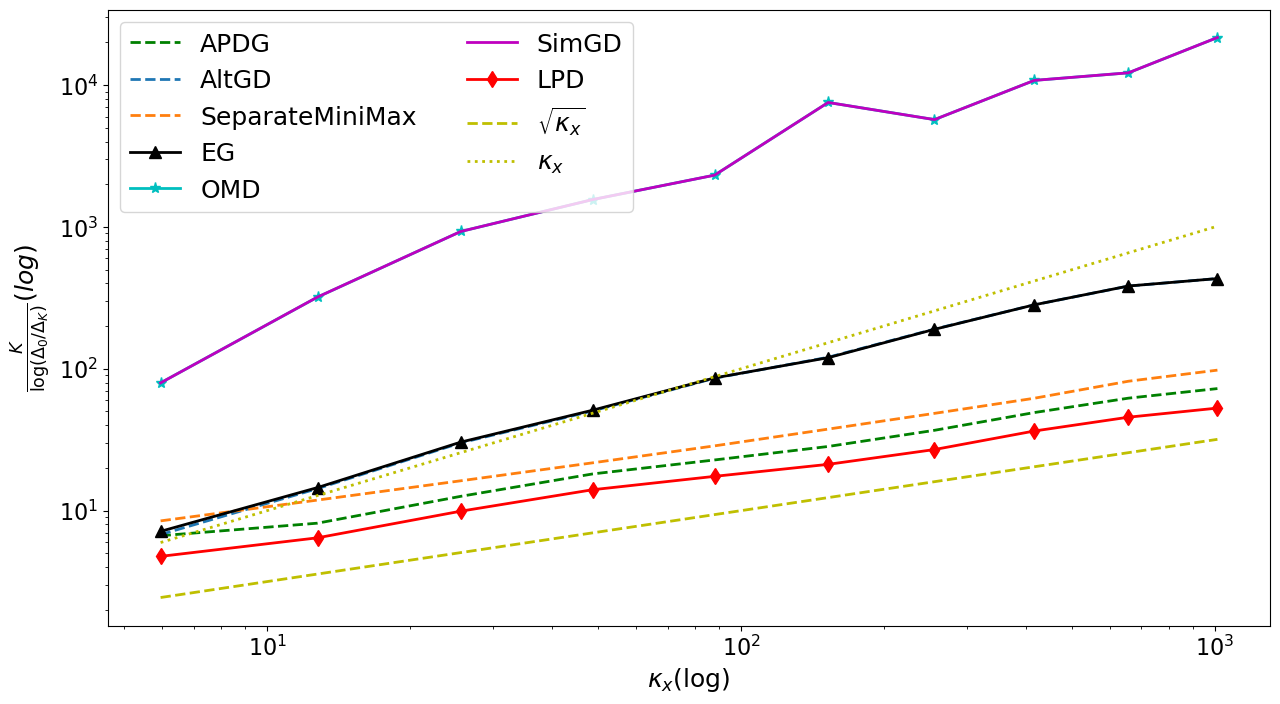

In [21]:
K = iteration
for method in methods_dict:
    plt.loglog(metric_lists['kappa_x'],
               K/np.log(metric_lists['initial']/metric_lists[method]).mean(axis=0),
               methods_dict[method]["marker"], label=method)


plt.loglog(metric_lists['kappa_x'], metric_lists['kappa_x']**0.5, 'y--', label=r'$\sqrt{\kappa_x}$')
plt.loglog(metric_lists['kappa_x'], metric_lists['kappa_x'], 'y:', label='$\kappa_x$')

print('kappa_x', metric_lists['kappa_x'])
print('sqrt(kappa_x)', metric_lists['kappa_x']**0.5)

plt.xlabel(r"$\kappa_x (\log)$")
plt.ylabel(r"$\frac{K}{\log(\Delta_0/\Delta_K)} (log)$")

plt.legend(ncol=2)
plotname = "Quadratic_kappa_x_loss_dependency"
plt.savefig(os.path.join("..", "figures", f'{plotname}.pdf'), bbox_inches='tight')
plt.savefig(os.path.join("..", "figures", f'{plotname}.png'), bbox_inches='tight')
plt.show()
plt.close()

## Not symmetric case

In [22]:
from sklearn.linear_model import LinearRegression 
import warnings
warnings.filterwarnings("ignore")

d_x = 5
d_y = 10

In [23]:
params = {"apdg": None,
          'altgd': None,
          'lpd': None,
          'simgd':  None,
          # 'avg':  None,
          'eg': None,
          'omd': None,
          'smm': None,
          # 'AA': {"lr": 1 / (2*L), 
          #        "k": 10,
          #        "type2": True,
          #        "reg": 1e-10,
          #        "gamma": 1e-26
          #       }
         }

metric_lists_ns = {
    'kappa_x': [],
    'APDG': [],
    'AltGD': [],
    'SimGD': [],
    'EG': [],
    "LPD": [],
    "SeparateMiniMax": [],
    "OMD": [],
    'initial': [],
}
model = LinearRegression()

EPS = 0
iteration = 1000
N_RUNS = 5
rvsx = lambda: ortho_group.rvs(dim=d_x)
rvsy = lambda: ortho_group.rvs(dim=d_y)
for _ in range(N_RUNS):
    for key in metric_lists_ns:
        metric_lists_ns[key].append([])
        
    for ratio in tqdm(np.arange(1.25, 2.25+0.25, 0.125),position=0):
        x0 = np.random.randn(d_x, )
        y0 = np.random.randn(d_y, )
        _d = min(d_x, d_y)
        eigvals = np.ones([_d])*(ratio**np.arange(0,_d, 1))
        if d_x < d_y:
            mA = np.concatenate((np.diag(eigvals), np.zeros([d_x, d_y - _d])), axis=1)
        else:
            mA = np.concatenate((np.diag(eigvals), np.zeros([d_x - _d, d_y])), axis=0)
        A = rvsx().dot(mA).dot(rvsy()).T
        B = rvsx().dot(np.diag(np.linspace(eigvals.min(), eigvals.max(), d_x))).dot(rvsx())
        B = B.T.dot(B)
        C = rvsy().dot(np.diag(np.linspace(eigvals.min(), eigvals.max(), d_y))).dot(rvsy())
        C = C.T.dot(C)
       
        problem_n = pr.BilinearQuadraticSaddle(A=A, B=B, C=C)

        methods_dict = ut.main(problem_n, iteration,
                               x0.copy(), y0.copy(),
                               params, eps=EPS, verbose=0)
        metric_lists_ns['kappa_x'][-1].append(problem_n.L_x/problem_n.mu_x)
        metric_lists_ns['initial'][-1].append(methods_dict["APDG"]["loss_hist"][0])
        for method in methods_dict:
            metric_lists_ns[method][-1].append(methods_dict[method]["loss_hist"][-1])

for key in metric_lists_ns:
    metric_lists_ns[key] = np.array(metric_lists_ns[key])
metric_lists_ns['kappa_x'] = metric_lists_ns['kappa_x'].mean(axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.21s/it]


kappa_x [   5.96046448   12.77678496   25.62890625   48.62133986   87.96388245
  152.7601853   256.          415.78754431  656.84083557 1012.29924208]
sqrt(kappa_x) [ 2.44140625  3.57446289  5.0625      6.97290039  9.37890625 12.35961914
 16.         20.39086914 25.62890625 31.81665039]


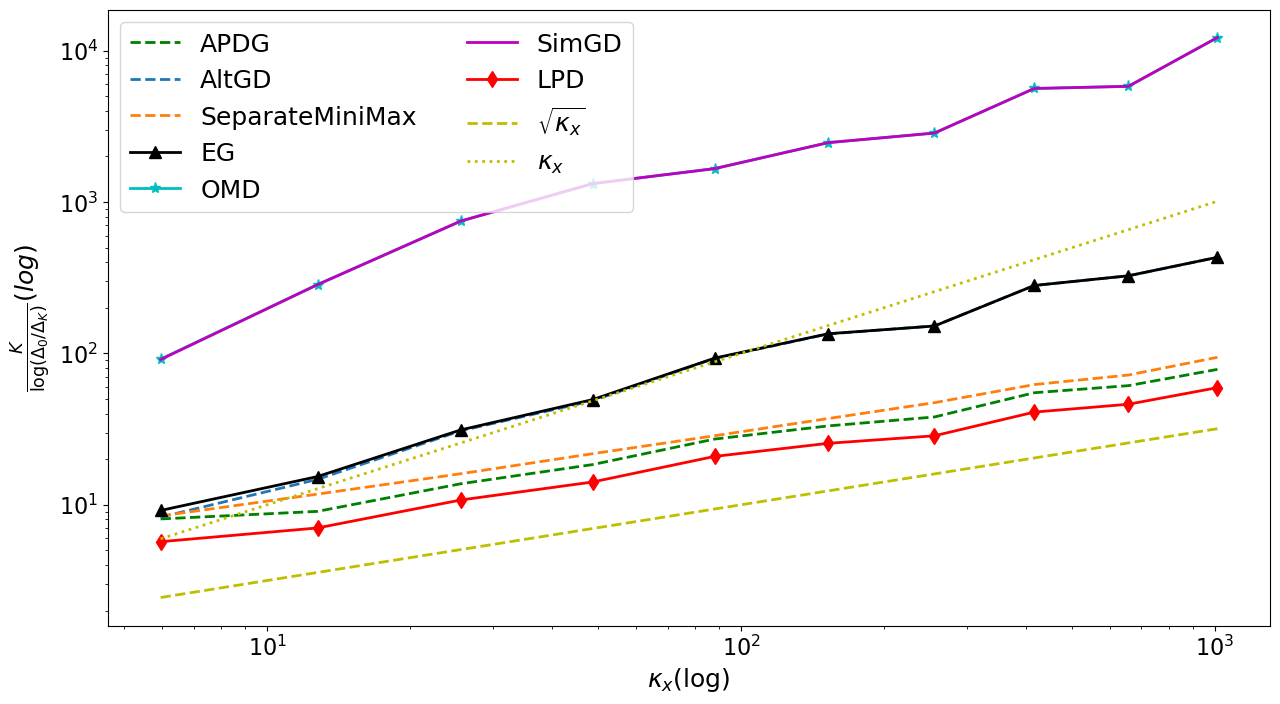

In [25]:
K = iteration
for method in methods_dict:
    plt.loglog(metric_lists_ns['kappa_x'],
               K/np.log(metric_lists_ns['initial']/metric_lists_ns[method]).mean(axis=0),
               methods_dict[method]["marker"], label=method)


plt.loglog(metric_lists_ns['kappa_x'], metric_lists_ns['kappa_x']**0.5, 'y--', label=r'$\sqrt{\kappa_x}$')
plt.loglog(metric_lists_ns['kappa_x'], metric_lists_ns['kappa_x'], 'y:', label='$\kappa_x$')

print('kappa_x', metric_lists_ns['kappa_x'])
print('sqrt(kappa_x)', metric_lists_ns['kappa_x']**0.5)

plt.xlabel(r"$\kappa_x (\log)$")
plt.ylabel(r"$\frac{K}{\log(\Delta_0/\Delta_K)} (log)$")

plt.legend(ncol=2)
plotname = f"Quadratic_kappa_x_loss_dependency_dx{d_x}_dy{d_y}"
plt.savefig(os.path.join("..", "figures", f'{plotname}.pdf'), bbox_inches='tight')
plt.savefig(os.path.join("..", "figures", f'{plotname}.png'), bbox_inches='tight')
plt.show()
plt.close()